<a href="https://colab.research.google.com/github/lnikam1811/Learning_PyTorch/blob/master/02_PyTorch_Neural_Nework_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Architecture of a classification neural network



# 1. Make classification data and get it ready

In [29]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise = 0.03, # a little bit of noise to the dots
                    random_state = 42) #keep random state so we get the same value

print(f"First 5 X feature:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X feature:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [30]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [31]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

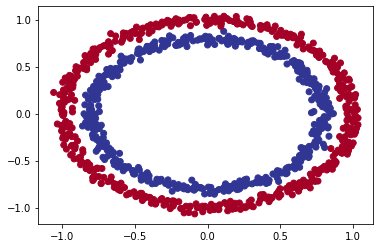

In [32]:
# Visulize with a plot
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

Lets find out how we could build a PyTorch neural network to classify dots into red(0) or blue(1)

# 1.1 Input and output shapes

In [33]:
#  Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [34]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


second dimesnion for `x` means it has two features (vector)

where as `y` has a single feature (scalar)

# 1.2 Turn data into tensors and create train and test splits

In [35]:
# Turn data into tensors
# otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [36]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2. Building a model


In [37]:
from torch import nn

# make devic agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

1. subclasses `nn.Module`
2. Create 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.

In [38]:
# 1
class CircleModel1V0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  # 3
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

# 4
model_0 = CircleModel1V0().to(device)
model_0

CircleModel1V0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [39]:
# Replicate CircleModelV0 with nn.Sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

In [40]:
#  Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n {untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
 tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], grad_fn=<SliceBackward0>)

First 10 test labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# 2.1 Setup loss functions and optimizer
lets use a binary cross entropy loss function

1. `torch.nn.BCELoss()` measures the BCE b/w the label and features.
2. `torch.nn.BCEWithLogitsLoss()` same as above, but it has sigmoid layer (`nn.Sigmoid`) built-in

In [41]:
# create a loss fucntion
# loss_fn = nn.BCELoss() 

loss_fn = nn.BCEWithLogitsLoss()

# creates an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [42]:
# Calculate accuray for evaluation metric

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# 3. Train Model
3.1 going from raw model outputs to predicted label
(logits -> predcition probabilities -> prediction labels)

In [43]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], grad_fn=<SliceBackward0>)

In [44]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], grad_fn=<SigmoidBackward0>)

In [45]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# in_full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [46]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

# 3.2 Building a training and testing loop


In [47]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## training
  model_0.train()

  # 1. forward pass (model outputs raw logits)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calculate loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
    
  # Print out whats happening every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
                                              
                          

Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 10 | Loss: 0.69403, Accuracy: 50.00% | Test loss: 0.69615, Test acc: 50.00%
Epoch: 20 | Loss: 0.69343, Accuracy: 46.00% | Test loss: 0.69585, Test acc: 48.50%
Epoch: 30 | Loss: 0.69321, Accuracy: 49.00% | Test loss: 0.69577, Test acc: 47.50%
Epoch: 40 | Loss: 0.69312, Accuracy: 49.50% | Test loss: 0.69573, Test acc: 46.50%
Epoch: 50 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69569, Test acc: 46.50%
Epoch: 60 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69564, Test acc: 46.50%
Epoch: 70 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69559, Test acc: 46.50%
Epoch: 80 | Loss: 0.69304, Accuracy: 50.75% | Test loss: 0.69553, Test acc: 46.50%
Epoch: 90 | Loss: 0.69303, Accuracy: 50.38% | Test loss: 0.69547, Test acc: 46.50%


# 4. Make predictions and evaluate the model

In [48]:
import requests
from pathlib import Path

# Download helper functions from learn pytorch repo 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


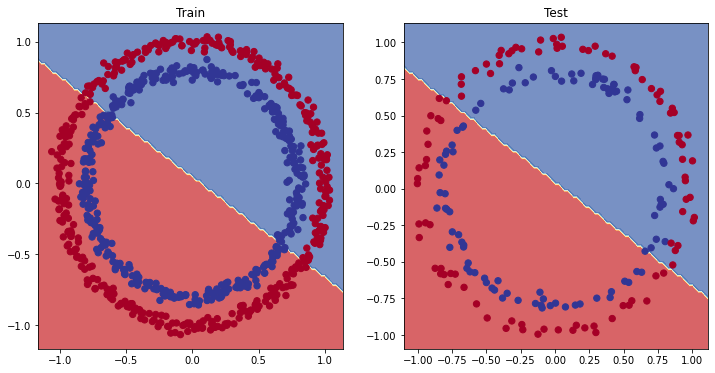

In [49]:
# Plot decision boundaries for training and test ets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. improving a model (from a model perspective)

Lets add an extra layer to our model, fit for longer (epochs =1000
instead of epochs =100) and increase the number of hidden units from 5 to 10


In [50]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

    def forward(self, x):
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_1(z)
        # z = self.layer_1(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [52]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


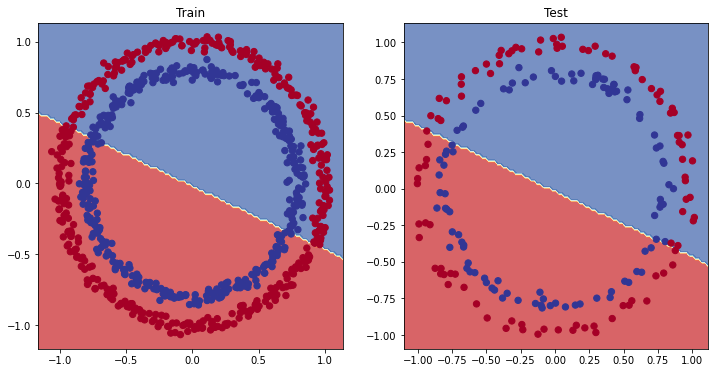

In [53]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [54]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [55]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.3)

In [56]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69306, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68796, Accuracy: 53.00% | Test Loss: 0.68720, Test Accuracy: 56.00%
Epoch: 200 | Loss: 0.67525, Accuracy: 54.37% | Test Loss: 0.67280, Test Accuracy: 56.50%
Epoch: 300 | Loss: 0.62461, Accuracy: 73.75% | Test Loss: 0.62162, Test Accuracy: 78.50%
Epoch: 400 | Loss: 0.37448, Accuracy: 97.38% | Test Loss: 0.40781, Test Accuracy: 92.50%
Epoch: 500 | Loss: 0.36910, Accuracy: 76.75% | Test Loss: 0.45300, Test Accuracy: 73.50%
Epoch: 600 | Loss: 0.08191, Accuracy: 100.00% | Test Loss: 0.11981, Test Accuracy: 97.50%
Epoch: 700 | Loss: 0.04117, Accuracy: 100.00% | Test Loss: 0.06974, Test Accuracy: 99.00%
Epoch: 800 | Loss: 0.02686, Accuracy: 100.00% | Test Loss: 0.04934, Test Accuracy: 99.00%
Epoch: 900 | Loss: 0.01987, Accuracy: 100.00% | Test Loss: 0.04013, Test Accuracy: 99.00%


In [57]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

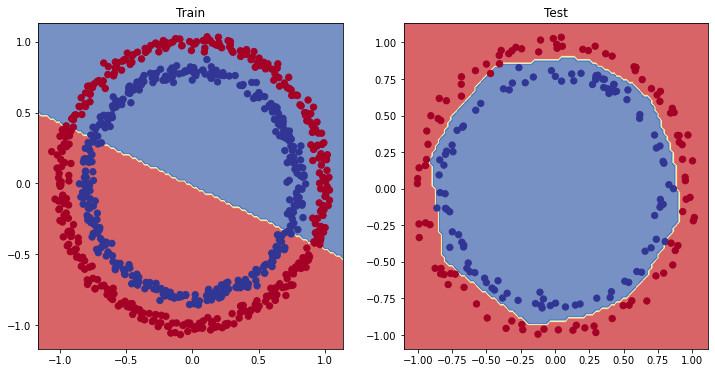

In [58]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Multi-class PyTorch model
1. creating multi-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


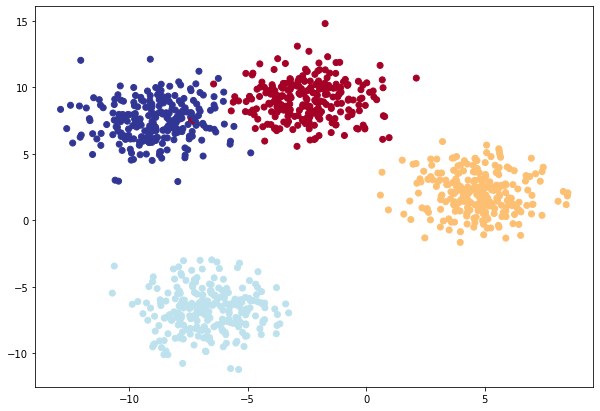

In [59]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

# 4. Plot data
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu);

8.2 Building a multi-class classification model in PyTorch

In [60]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [61]:
from torch import nn

# build model

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = output_features)
      )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features = NUM_FEATURES,
                    output_features = NUM_CLASSES,
                    hidden_units = 8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [62]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr = 0.1)

8.4 getting prediction probabilities for a multi-class PyTorch model

In [63]:
# Perform a single forward pass on the data 
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [64]:
# How many elements in a single predecition sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

**That's where the softmax activation function comes into play.**

**The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.**

In [65]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [66]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [67]:
# which class does the model think it most likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


8.5 Creating a training and testing loop for a multi-class PyTorch model

In [69]:
torch.manual_seed(42)

epochs=100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  # 1.Forward pass
  y_logits = model_4(X_blob_train) #model outputs raw logits
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)

  # 3.optimizer zero grad
  optimizer.zero_grad()

  # 4.loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                         y_pred = test_pred)
  
  
  if epoch % 10 == 0:
     print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.57519, Acc: 95.38% | Test Loss: 0.42672, Test Acc: 97.50%
Epoch: 10 | Loss: 0.13289, Acc: 99.12% | Test Loss: 0.12048, Test Acc: 99.00%
Epoch: 20 | Loss: 0.07753, Acc: 99.12% | Test Loss: 0.06920, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05788, Acc: 99.12% | Test Loss: 0.04999, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04818, Acc: 99.00% | Test Loss: 0.04023, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04249, Acc: 99.00% | Test Loss: 0.03438, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03879, Acc: 99.00% | Test Loss: 0.03051, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03621, Acc: 99.00% | Test Loss: 0.02775, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03431, Acc: 99.12% | Test Loss: 0.02569, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03287, Acc: 99.12% | Test Loss: 0.02409, Test Acc: 99.50%


8.6 Making and evaluating predictions with a PyTorch multi-class model

In [70]:
# make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3551,  10.3920, -14.9378,  -9.7940],
        [  5.0249, -12.0799,   3.3984,  10.6999],
        [ -5.6140, -13.3927,  21.0484,  12.8085],
        [  1.8479,   7.5879,  -8.6272,  -7.0156],
        [  8.0997,   3.3034, -14.6397,  -3.6309],
        [  5.5958, -15.0054,   5.0344,  13.3266],
        [ -5.9993, -10.2278,  18.9179,   9.9470],
        [  7.0976,  -0.7620,  -9.5784,   0.1726],
        [ -5.6194, -18.6659,  25.6036,  17.6314],
        [  7.3378,   0.7231, -11.2318,  -1.2062]])

In [71]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities intro prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model pred and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


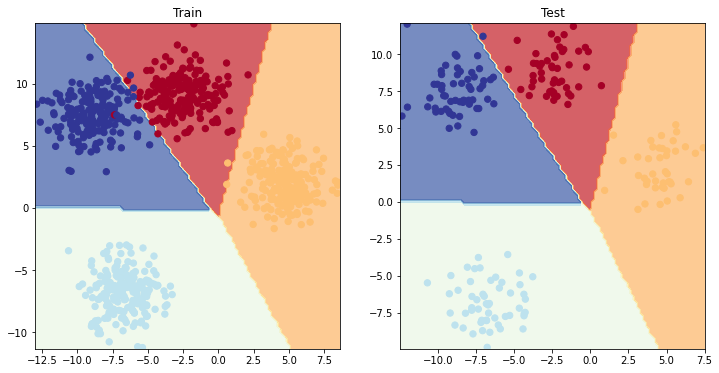

In [72]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)